In [604]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler


In [605]:
#loading the data

df = pd.read_csv('../data_pipeline/output.csv')

# Data Preparation

In [606]:

df



,id,priority,priority_id,issue_type,description,summary
0,493199,normal,4,bug,[minecraft: java edition achievements faq|http...,"""minecraft: java edition achievements faq"" has..."
1,493198,normal,4,bug,[minecraft: java edition achievements faq|http...,"""minecraft: java edition achievements faq"" has..."
2,493172,normal,4,bug,https://help.minecraft.net/hc/en-us/articles/4...,"""minecraft: java edition demo mode"" article ha..."
3,493170,normal,4,bug,[minecraft - types of biomes|https://help.mine...,"""minecraft - types of biomes"" is not updated t..."
4,493168,normal,4,bug,[minecraft - list of enchantments|https://help...,"""minecraft - list of enchantments"" has an extr..."
...,...,...,...,...,...,...
3433,110671,low,5,bug,https://twitter.com/mojangsupport/status/57484...,incorrect translation on korean realms page.
3434,106111,normal,4,bug,the results when using the {{at}} parameter fo...,api.mojang.com/users/profiles/minecraft/<name>...
3435,113486,normal,4,bug,this is the actual account claimed by [jumboki...,demo accounts are returned by the api
3436,88817,normal,4,bug,"summary says it all, the api is occasionally n...",mojang's api for retrieving players from uuids...


In [607]:
#preparing the description and summary data to be used in the model for NLP

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#preparing description_summary for the model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords





## Removing characters that may add noise to the model

In [608]:
def clean_and_tfidf(df):

    #deleting priority column
    df = df.drop(columns=['priority']) #this won't be used in the model, we already gave the id one

    #deleting the issue_type column
    df = df.drop(columns=['issue_type']) #this won't be used in the model, we already gave the id one

    #creating a new column with the description and summary combined
    df['description_summary'] = df['description'] + ' ' + df['summary']

    #deleting the description and summary columns
    df = df.drop(columns=['description'])
    df = df.drop(columns=['summary'])

    stop = stopwords.words('english')
    df['description_summary'] = df['description_summary'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Remove rows with language-specific characters
    patterns = [
        'ä|ö|ü|ß',  # German
        'é|è|à|ç',  # French
        'á|é|í|ó|ú|ñ',  # Spanish
        'à|è|ì|ò|ù',  # Italian
        'ã|õ|ç',  # Portuguese
        'ą|ć|ę|ł|ń|ó|ś|ź|ż',  # Polish
        'а|б|в|г|д|е|ё|ж|з|и|й|к|л|м|н|о|п|р|с|т|у|ф|х|ц|ч|ш|щ|ъ|ы|ь|э|ю|я',  # Russian
        'ş|ç|ğ|ı|ö|ü',  # Turkish
        'ا|ب|ت|ث|ج|ح|خ|د|ذ|ر|ز|س|ش|ص|ض|ط|ظ|ع|غ|ف|ق|ك|ل|م|ن|ه|و|ي',  # Arabic
        'の|で|ます|し|こと|です|いる|が|に|を|は|と|た|して|も|ない|か|ん|ある|な|い|できる|おり|する|ため|さ|れ',  # Japanese
        '的|了|和|是|就|都|而|及|與|著|或|一個|沒有|我們|你們|妳們|他們|她們|是否|可以|這個|這些|那個|那些|因為|所以|如果|但是|然而|然後|因此',  # Chinese
        '의|가|이|은|들|는|좀|잘|걍|과|도|를|으로',  # Korean
        'के|का|एक|में|है|और|से|हैं|को|पर|इस|होता|कि|जो|कर|मे|गया|करने|किया|लिये|अपने|ने|बनी|नही|तो|ही|या|एवं|दिया|हो|इसका|था|द्वारा|हुआ|तक|साथ|करना|वाले|बाद|लिए|आप|कुछ|सकते|किसी|ये|इसके|सबसे|इसमें|थे|दो|होने|वह|वे|करते|बहुत|कहा|वर्ग|कई|करें|होती|अपनी|उनके|यदि|हुई|जा|कहते|जब|होते|कोई|हुए|वग़ैरह'  # Hindi
    ]
    
    for pattern in patterns:
        df = df[~df['description_summary'].str.contains(pattern, regex=True)]

    #remove numbers e.g. 100, 2021,etc.
    df['description_summary'] = df['description_summary'].str.replace(r'\d+', '', regex=True)
    
    
    
    # Clean the description_summary column
    df['description_summary'] = df['description_summary'].str.replace(r'\[.*?\]', '', regex=True)
    df['description_summary'] = df['description_summary'].str.replace(r'http\S+', '', regex=True)
    df['description_summary'] = df['description_summary'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    df['description_summary'] = df['description_summary'].apply(
        lambda x: ' '.join([word for word in str(x).split() if word not in stop])
    )

    #delete word if it has com as last 3 characters
    df['description_summary'] = df['description_summary'].apply(lambda x: ' '.join([word for word in x.split() if word[-3:] != 'com']))
    
    
    #Stemming
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    df['description_summary'] = df['description_summary'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


    # Reset the index
    df = df.reset_index(drop=True)
    
    # Apply TFIDF transformation
    tfidf_vectorizer = TfidfVectorizer(max_features=2500)
    tfidf_result = tfidf_vectorizer.fit_transform(df['description_summary']).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df = tfidf_df.add_prefix('TFID_')
    
    # Merge the TFIDF features back into the dataframe and drop the original description_summary column
    df = pd.concat([df, tfidf_df], axis=1)
    df = df.drop(columns=['description_summary'])
    
    return df

df = clean_and_tfidf(df)


In [609]:
df

,id,priority_id,TFID_aa,TFID_ab,TFID_abil,TFID_abl,TFID_absolut,TFID_abus,TFID_acbeb,TFID_acc,...,TFID_za,TFID_zerocorejar,TFID_zhhan,TFID_zip,TFID_zm,TFID_zo,TFID_zombi,TFID_zoom,TFID_zp,TFID_zr
0,493199,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,493198,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,493172,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,493170,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,493168,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,99628,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,106111,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,113486,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,88817,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [610]:
df = df.drop(df[df['priority_id'] == 4].sample(3000).index)

#oversample with SMOTE
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['priority_id'])
y = df['priority_id']

smote = SMOTE(sampling_strategy='auto', k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X, y)

df = pd.concat([X_sm, y_sm], axis=1)



In [611]:
#get count by priority_id 1, 2, 3, 4

#dropping 1200 rows from priority_id 4 to balance the dataset
df['priority_id'].value_counts()


priority_id
4    51
3    51
5    51
2    51
1    51
Name: count, dtype: int64

In [612]:
df

,id,TFID_aa,TFID_ab,TFID_abil,TFID_abl,TFID_absolut,TFID_abus,TFID_acbeb,TFID_acc,TFID_accept,...,TFID_zerocorejar,TFID_zhhan,TFID_zip,TFID_zm,TFID_zo,TFID_zombi,TFID_zoom,TFID_zp,TFID_zr,priority_id
0,493166,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,490903,0.0,0.0,0.0,0.147060,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,480154,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,468965,0.0,0.0,0.0,0.081154,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,467713,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,188474,0.0,0.0,0.0,0.000000,0.035205,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
251,192537,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
252,269944,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
253,161282,0.0,0.0,0.0,0.022850,0.000000,0.041485,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [613]:
#creating the training and test data
from sklearn.model_selection import train_test_split

X = df.drop(columns=['priority_id'])
y = df['priority_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#scaling the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





In [614]:
#Creating the model 

#using a random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [615]:
#predicting the test data
y_pred = rf.predict(X_test)





              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      0.90      0.95        21
           3       1.00      0.64      0.78        11
           4       0.77      0.83      0.80        12
           5       0.54      0.88      0.67         8

    accuracy                           0.86        64
   macro avg       0.86      0.85      0.84        64
weighted avg       0.90      0.86      0.87        64



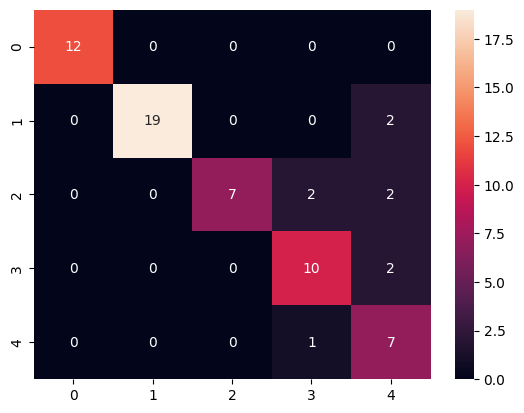

In [616]:
#evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

#plotting with seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

#accuracy, precision, recall, f1-score
print(classification_report(y_test, y_pred))


## Increasing test size but keeping the same model, just to test

In [617]:
#creating the training and test data, increasing the test size of UNSEEN DATA.
from sklearn.model_selection import train_test_split

X2 = df.drop(columns=['priority_id'])
y2 = df['priority_id']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.6, random_state=42)

#scaling the data
scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        32
           2       1.00      0.94      0.97        32
           3       1.00      0.88      0.94        33
           4       0.89      1.00      0.94        32
           5       0.85      0.92      0.88        24

    accuracy                           0.95       153
   macro avg       0.95      0.95      0.94       153
weighted avg       0.95      0.95      0.95       153



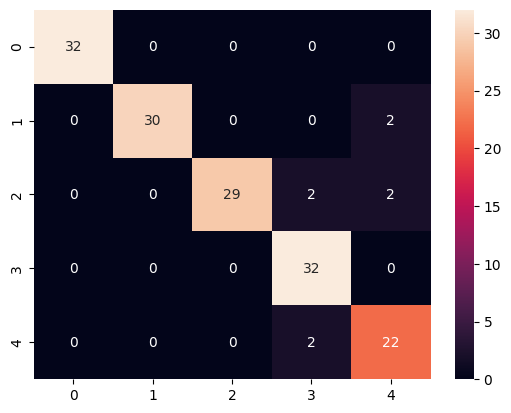

In [618]:
#predicting the test data
y_pred2 = rf.predict(X_test2)

#evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

#plotting with seaborn
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True)

#accuracy, precision, recall, f1-score
print(classification_report(y_test2, y_pred2))



## Bringing the original dataset without oversampling, let's see what happens.

In [619]:
df_unseen = pd.read_csv('../data_pipeline/unseen_output.csv')

In [620]:
df_unseen_mod = clean_and_tfidf(df_unseen)

In [621]:
X_new = df_unseen_mod.drop(columns=['priority_id'], errors='ignore')

X_new = scaler.transform(X_new)





In [622]:
prediction = rf.predict(X_new)

In [623]:
#get count from prediction
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))




{1: 2, 2: 3, 3: 46, 4: 2526, 5: 553}

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.60      0.75         5
           3       0.39      0.82      0.53        22
           4       1.00      0.83      0.90      3051
           5       0.09      0.96      0.16        50

    accuracy                           0.83      3130
   macro avg       0.70      0.84      0.67      3130
weighted avg       0.98      0.83      0.89      3130



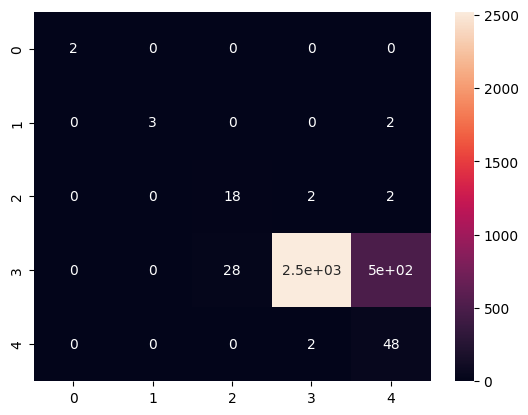

In [624]:
#plotting the prediction with confusion matrix
cm = confusion_matrix(df_unseen_mod['priority_id'], prediction)
sns.heatmap(cm, annot=True)

#accuracy, precision, recall, f1-score
print(classification_report(df_unseen_mod['priority_id'], prediction))




In [479]:
#joining original data with the prediction in new dataframe called final
final = pd.concat([df_unseen, pd.Series(prediction, name='predicted_priority_id')], axis=1)

final

,id,priority,priority_id,issue_type,description,summary,predicted_priority_id
0,493199,normal,4,bug,[minecraft: java edition achievements faq|http...,"""minecraft: java edition achievements faq"" has...",4.0
1,493198,normal,4,bug,[minecraft: java edition achievements faq|http...,"""minecraft: java edition achievements faq"" has...",4.0
2,493172,normal,4,bug,https://help.minecraft.net/hc/en-us/articles/4...,"""minecraft: java edition demo mode"" article ha...",5.0
3,493170,normal,4,bug,[minecraft - types of biomes|https://help.mine...,"""minecraft - types of biomes"" is not updated t...",4.0
4,493168,normal,4,bug,[minecraft - list of enchantments|https://help...,"""minecraft - list of enchantments"" has an extr...",4.0
...,...,...,...,...,...,...,...
3433,110671,low,5,bug,https://twitter.com/mojangsupport/status/57484...,incorrect translation on korean realms page.,NaN
3434,106111,normal,4,bug,the results when using the {{at}} parameter fo...,api.mojang.com/users/profiles/minecraft/<name>...,NaN
3435,113486,normal,4,bug,this is the actual account claimed by [jumboki...,demo accounts are returned by the api,NaN
3436,88817,normal,4,bug,"summary says it all, the api is occasionally n...",mojang's api for retrieving players from uuids...,NaN


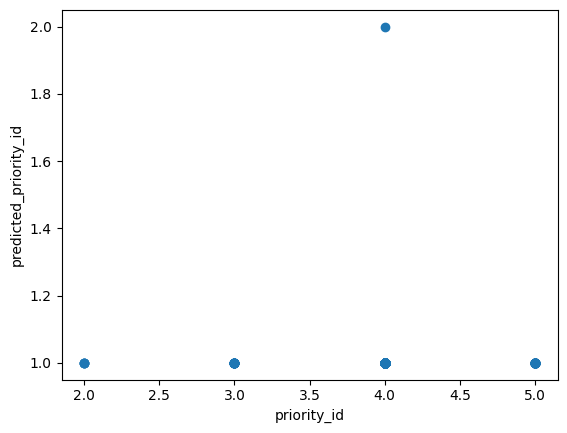

In [352]:
#scatter plot priority_id vs predicted_priority_id
plt.scatter(final['priority_id'], final['predicted_priority_id'])
plt.xlabel('priority_id')
plt.ylabel('predicted_priority_id')
plt.show()